In [6]:
!pip install segmentation_models patchify swig smac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 20.9 MB/s 
     |████████████████████████████████| 202 kB 82.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 50 kB 8.3 MB/s 
     |████████████████████████████████| 5.7 MB 80.9 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 4.4 MB 61.3 MB/s 
  Created wheel for smac: filename=smac-1.4.0-py3-none-any.whl size=262351 sha256=ca6fad60a46739145f6bbff73f7c41debd917475347196159c7c38342939c60f
  Stored in directory: /root/.cache/pip/wheels/ac/6d/af/dfaf46d1944e1b4d84f51afef798145a0f0e1b9b9a93842edc
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7044 sha256=6e28968ccb1ecbb4b4e20b67f2df00951271adca8badeea4278e2c237b1933fe
  Stored in directory: /

In [3]:
!pip install urllib3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%cd drive/MyDrive/miles4

/content/drive/MyDrive/miles4


In [19]:
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!unzip archive.zip

Archive:  archive.zip
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_009.jpg  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_001.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_002.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_003.png  
  inflating: Semantic segmentation dataset/Ti

Segmentation Models: using `keras` framework.
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1/images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2/images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2/images/image_part_008.jpg
Now patc

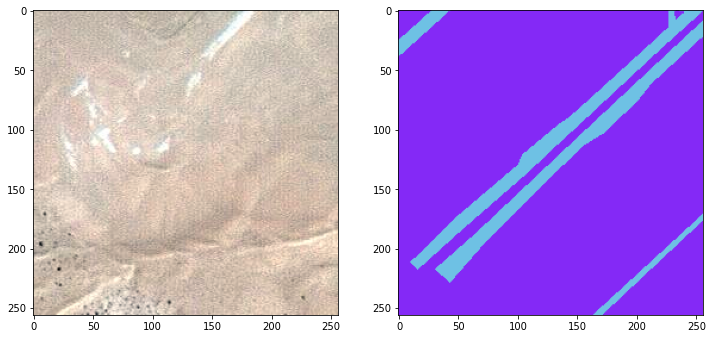

60
Unique labels in label dataset are:  [0 1 2 3 4 5]


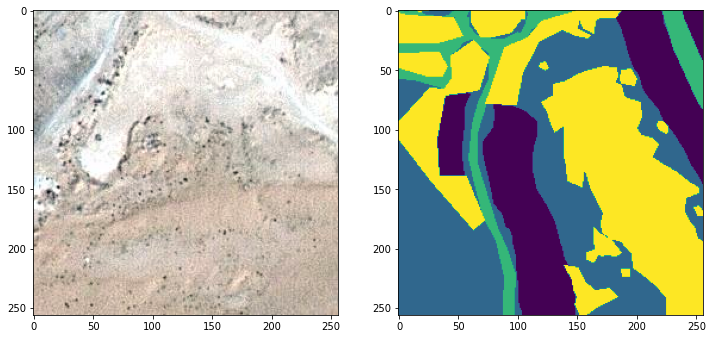

In [7]:
# https://youtu.be/jvZm8REF2KY
"""
Explanation of using RGB masks: https://youtu.be/sGAwx4GMe4E

https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B

Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256

"""

import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = "Semantic segmentation dataset"

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
  
                
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()
###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


############################################################################

n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


#######################################
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
n_classes=6



In [8]:
# https://youtu.be/jvZm8REF2KY
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers. 
"""


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy',jacard_coef]

################################################################
def multi_unet_model(c1_filter_1,c1_dropout,c1_filter_2,c1_k,c2_filter_1,c2_dropout,c2_filter_2,c2_k,c3_filter_1,c3_dropout,c3_filter_2,c3_k,c4_filter_1,c4_dropout,c4_filter_2,c4_k,c5_filter_1,c5_dropout,c5_filter_2,c5_k,c6_filter_1,c6_dropout,c6_filter_2,c6_k,c7_filter_1,c7_dropout,c7_filter_2,c7_k,c8_filter_1,c8_dropout,c8_filter_2,c8_k,c9_filter_1,c9_dropout,c9_filter_2,c9_k,metrics=['accuracy',jacard_coef],n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(c1_filter_1, (3, 3), activation='relu', kernel_initializer=c1_k, padding='same')(s)
    c1 = Dropout(c1_dropout)(c1)  # Original 0.1
    c1 = Conv2D(c1_filter_2, (3, 3), activation='relu', kernel_initializer=c1_k, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(c2_filter_1, (3, 3), activation='relu', kernel_initializer=c2_k, padding='same')(p1)
    c2 = Dropout(c2_dropout)(c2)  # Original 0.1
    c2 = Conv2D(c2_filter_2, (3, 3), activation='relu', kernel_initializer=c2_k, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(c3_filter_1, (3, 3), activation='relu', kernel_initializer=c3_k, padding='same')(p2)
    c3 = Dropout(c3_dropout)(c3)
    c3 = Conv2D(c3_filter_2, (3, 3), activation='relu', kernel_initializer=c3_k, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(c4_filter_1, (3, 3), activation='relu', kernel_initializer=c4_k, padding='same')(p3)
    c4 = Dropout(c4_dropout)(c4)
    c4 = Conv2D(c4_filter_2, (3, 3), activation='relu', kernel_initializer=c4_k, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(c5_filter_1, (3, 3), activation='relu', kernel_initializer=c5_k, padding='same')(p4)
    c5 = Dropout(c5_dropout)(c5)
    c5 = Conv2D(c5_filter_2, (3, 3), activation='relu', kernel_initializer=c5_k, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(c6_filter_1, (3, 3), activation='relu', kernel_initializer=c6_k, padding='same')(u6)
    c6 = Dropout(c6_dropout)(c6)
    c6 = Conv2D(c6_filter_2, (3, 3), activation='relu', kernel_initializer=c6_k, padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(c7_filter_1, (3, 3), activation='relu', kernel_initializer=c7_k, padding='same')(u7)
    c7 = Dropout(c7_dropout)(c7)
    c7 = Conv2D(c7_filter_2, (3, 3), activation='relu', kernel_initializer=c7_k, padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(c8_filter_1, (3, 3), activation='relu', kernel_initializer=c8_k, padding='same')(u8)
    c8 = Dropout(c8_dropout)(c8)  # Original 0.1
    c8 = Conv2D(c8_filter_2, (3, 3), activation='relu', kernel_initializer=c8_k, padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(c9_filter_1, (3, 3), activation='relu', kernel_initializer=c9_k, padding='same')(u9)
    c9 = Dropout(c9_dropout)(c9)  # Original 0.1
    c9 = Conv2D(c9_filter_2, (3, 3), activation='relu', kernel_initializer=c9_k, padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    
    #model.summary()
    
    return model
 

In [9]:
params={"c1_dropout": 0.2078336298722035, "c1_filter_1": 256, "c1_filter_2": 64, "c1_k": "he_normal", "c2_dropout": 0.1929614810528824, "c2_filter_1": 16, "c2_filter_2": 64, "c2_k": "he_normal", "c3_dropout": 0.25073350643918524, "c3_filter_1": 64, "c3_filter_2": 32, "c3_k": "he_normal", "c4_dropout": 0.13241094303389792, "c4_filter_1": 16, "c4_filter_2": 64, "c4_k": "he_uniform", "c5_dropout": 0.2890382397840315, "c5_filter_1": 16, "c5_filter_2": 256, "c5_k": "he_uniform", "c6_dropout": 0.24714526452305166, "c6_filter_1": 32, "c6_filter_2": 64, "c6_k": "he_uniform", "c7_dropout": 0.11074729321431534, "c7_filter_1": 16, "c7_filter_2": 16, "c7_k": "he_uniform", "c8_dropout": 0.12554967275269419, "c8_filter_1": 64, "c8_filter_2": 64, "c8_k": "he_normal", "c9_dropout": 0.20359880854967072, "c9_filter_1": 128, "c9_filter_2": 128, "c9_k": "he_uniform"}

In [10]:
import os
import tensorflow as tf


class DistillationModel(tf.keras.Model):
    def __init__(self, teacher_model, student_model):
        super(DistillationModel, self).__init__()
        self.teacher_model = teacher_model
        self.student_model = student_model

    def compile(self, optimizer, metrics, loss, alpha=0.1, temperature=3):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        #self.student_model.compile(optimizer=optimizer, metrics=metrics, loss='binary_crossentropy')
        self.loss = loss
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        logits_teacher = self.teacher_model(x, training=False)

        with tf.GradientTape() as tape:
            logits_student = self.student_model(x, training=True)
            normal_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y, logits_student)
            distil_loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(logits_teacher / self.temperature),
                                                         tf.nn.softmax(logits_student / self.temperature))
            total_loss = (1 - self.alpha) * normal_loss + self.alpha * (self.temperature**2) * distil_loss

        trainable_vars = self.student_model.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, tf.nn.softmax(logits_student))

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": normal_loss,
                        "distil_loss": distil_loss,
                        "total_loss": total_loss})
        return results

    def test_step(self, data):
        x, y = data

        logits_student = self.student_model(x, training=False)

        student_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y, logits_student)

        self.compiled_metrics.update_state(y, tf.nn.softmax(logits_student))

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [11]:
from datetime import datetime

print('==================teacher model training==================')
start_time = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')

model=multi_unet_model(**params)

==================teacher model training==================


In [27]:
model_save_dir = 'model_teacher(' + start_time + ')'
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

check_point_save_dir = 'checkpoints' + start_time
os.mkdir(check_point_save_dir)
check_point_filename = 'Unet_Teacher_e{epoch:03d}-acc{accuracy:.2f}-val_acc{val_accuracy:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(check_point_save_dir, check_point_filename),
                                            verbose=1,  # 1 = progress bar
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            mode='max')
#early stoping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, mode='auto')
#reduce learning rate on plateau
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.7, patience=5, cooldown=10,
                                          min_lr=0.00001, mode='auto')
#add callbacks
callbacks_list = [checkpoint, early_stopping, reduce]

##train
print('--------------------------train---------------------------')
teacher_model=model
teacher_model.summary()
history1 = teacher_model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=2, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                     callbacks=callbacks_list,
                     
                                )
teacher_model.save(model_save_dir)


--------------------------train---------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 25  7168        ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 25  0           ['conv2d[0][0]']                 
                                6) 

In [28]:
def unet_logit(input_layer, classes, init_depth=16):
    conv1 = tf.keras.layers.Conv2D(init_depth, 3, padding='same', activation='relu', kernel_initializer='he_normal')(input_layer)
    conv1 = tf.keras.layers.Conv2D(init_depth, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv1)
    conv2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(init_depth*2, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv2)
    conv2 = tf.keras.layers.Conv2D(init_depth*2, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv2)
    conv3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(init_depth*4, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv3)
    conv3 = tf.keras.layers.Conv2D(init_depth*4, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv3)
    conv4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(init_depth*8, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv4)
    conv4 = tf.keras.layers.Conv2D(init_depth*8, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv4)
    conv5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(init_depth*16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv5)
    conv5 = tf.keras.layers.Conv2D(init_depth*16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv5)
    # up1 = tf.keras.layers.Conv2DTranspose(init_depth*16, 3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')(conv5)
    up1 = tf.keras.layers.Conv2D(init_depth * 16, 3, padding='same', activation='relu', kernel_initializer='he_normal')((tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)))
    concat1 = tf.keras.layers.concatenate([conv4, up1], axis=3)

    conv6 = tf.keras.layers.Conv2D(init_depth * 8, 3, padding='same', activation='relu', kernel_initializer='he_normal')(concat1)
    conv6 = tf.keras.layers.Conv2D(init_depth * 8, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv6)
    # up2 = tf.keras.layers.Conv2DTranspose(init_depth*8, 3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')(conv6)
    up2 = tf.keras.layers.Conv2D(init_depth * 8, 3, padding='same', activation='relu', kernel_initializer='he_normal')((tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)))
    concat2 = tf.keras.layers.concatenate([conv3, up2], axis=3)

    conv7 = tf.keras.layers.Conv2D(init_depth * 4, 3, padding='same', activation='relu', kernel_initializer='he_normal')(concat2)
    conv7 = tf.keras.layers.Conv2D(init_depth * 4, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv7)
    # up3 = tf.keras.layers.Conv2DTranspose(init_depth*4, 3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')(conv7)
    up3 = tf.keras.layers.Conv2D(init_depth * 4, 3, padding='same', activation='relu', kernel_initializer='he_normal')((tf.keras.layers.UpSampling2D(size=(2, 2))(conv7)))
    concat3 = tf.keras.layers.concatenate([conv2, up3], axis=3)

    conv8 = tf.keras.layers.Conv2D(init_depth * 2, 3, padding='same', activation='relu', kernel_initializer='he_normal')(concat3)
    conv8 = tf.keras.layers.Conv2D(init_depth * 2, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv8)
    # up4 = tf.keras.layers.Conv2DTranspose(init_depth*2, 3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')(conv8)
    up4 = tf.keras.layers.Conv2D(init_depth * 2, 3, padding='same', activation='relu', kernel_initializer='he_normal')((tf.keras.layers.UpSampling2D(size=(2, 2))(conv8)))
    concat4 = tf.keras.layers.concatenate([conv1, up4], axis=3)

    conv9 = tf.keras.layers.Conv2D(init_depth, 3, padding='same', activation='relu', kernel_initializer='he_normal')(concat4)
    conv9 = tf.keras.layers.Conv2D(init_depth, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv9)

    output_conv = tf.keras.layers.Conv2D(classes, 1, padding='same', kernel_initializer='he_normal')(conv9)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_conv)
    return model


In [29]:
import os
import tensorflow as tf


class CheckPoint(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = checkpoint_dir

    def on_epoch_end(self, epoch, logs=None):
        checkpoint_filename='Unet_Student_e{0:03d}-acc{1:.4f}-val_acc{2:.4f}-val_loss{3:.4f}.hdf5'.\
            format(epoch, logs['accuracy'],
                   logs['val_accuracy'],
                   logs['val_student_loss'])
        checkpoint_filepath = os.path.join(self.checkpoint_dir, checkpoint_filename)
        self.model.student_model.save_weights(checkpoint_filepath)

In [30]:
##build model
#teacher model
teacher_model_path = 'model_save_dir'
teacher_model = tf.keras.models.load_model(teacher_model_path)
input_t = teacher_model.input
output_t = teacher_model.layers[35].output
teacher_model = tf.keras.models.Model(input_t, output_t)
#student model
input_layer = tf.keras.layers.Input([640, 640, 1])
student_model = unet_logit(input_layer, classes=6, init_depth=16)
#model
model = DistillationModel(teacher_model=teacher_model, student_model=student_model)
metric = 'accuracy'
monitor_metric_name = 'val_accuracy'
#metric = tf.keras.metrics.Accuracy()
#monitor_metric_name = 'val_accuracy'
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)


#for transfer learning
#model.student_model.load_weights("D:/Public/qtkim/Knowledge_Distillation/model_student/checkpoints/2022_08_01-15_01_11/Unet_Student_e113-acc0.9626-val_acc0.9643-val_loss0.2462.hdf5")

#callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor_metric_name,
                                                patience=20, mode='auto')
reduce_rl = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor_metric_name, factor=0.7, patience=5,
                                            cooldown=10, min_lr=0.00001, mode='auto')
checkpoint = CheckPoint(checkpoint_dir=check_point_save_dir)
callbacks_list = [early_stopping, reduce_rl, checkpoint]

##train
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=2, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                     callbacks=callbacks_list,
                                )
model.student_model.save(model_save_dir)

OSError: ignored

In [ ]:
model = tf.keras.models.load_model(model_save_dir)
model.predict(X_test)

In [22]:
pwd


'/content/drive/MyDrive/miles4'